Import Library

In [26]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense,Dropout
from keras.models import Model 
from keras.layers import Input, Dense,Conv2D,Add
from keras import applications
from keras.layers import Activation,Add, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout,GlobalAveragePooling2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,load_model,Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.initializers import *
from keras import regularizers
from glob import glob
from tensorflow.keras.layers import SeparableConv2D,ReLU
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D


In [1]:
# Connect the drive with colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# File path of zip file uploaded on drive
file_path = "/content/drive/MyDrive/archive_2.zip"

In [3]:
!unzip file_path

unzip:  cannot find or open file_path, file_path.zip or file_path.ZIP.


In [4]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/My Drive/archive_2.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [5]:
# change the file path according to your pc
train_file_path = "/tmp/tiny-imagenet-200/tiny-imagenet-200/train"
test_file_path = "/tmp/tiny-imagenet-200/tiny-imagenet-200/test"

In [8]:
val_annotations = pd.read_csv('/tmp/tiny-imagenet-200/tiny-imagenet-200/val/val_annotations.txt', sep='\t', names=['image','target','a','b','c','d'])
print(type(val_annotations))
val_annotations.head()

<class 'pandas.core.frame.DataFrame'>


,image,target,a,b,c,d
0,val_0.JPEG,n03444034,0,32,44,62
1,val_1.JPEG,n04067472,52,55,57,59
2,val_2.JPEG,n04070727,4,0,60,55
3,val_3.JPEG,n02808440,3,3,63,63
4,val_4.JPEG,n02808440,9,27,63,48


In [33]:
# Creating an ImageDataGenerator object
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Load and iterate training data
train_generator = datagen.flow_from_directory(train_file_path, target_size=(128,128), class_mode='categorical', batch_size=128)

# Load and iterate validation data
val_generator = datagen.flow_from_dataframe(
                        val_annotations,
                        directory='/tmp/tiny-imagenet-200/tiny-imagenet-200/val/images',
                        x_col="image",
                        y_col="target",
                        target_size=(128,128),
                        color_mode="rgb",
                        class_mode="categorical",
                        batch_size=64,
                        shuffle=True
                        )

Found 100000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.


In [34]:
# Load and iterate test data
test_generator = datagen.flow_from_directory(
    test_file_path, target_size=(128,128), class_mode=None, batch_size= 64, shuffle=False
    )

Found 10000 images belonging to 1 classes.


In [35]:
test_generator[0].shape

(64, 128, 128, 3)

Let's try with Xception pre trained model

In [12]:
# 1st layer is Xception layer, used through transfer learning
xception = tf.keras.applications.Xception(
                include_top=False,
                weights="imagenet",
                input_shape=(128,128,3),
                pooling='avg'
            )

# Since we are going to use the weights alredy trained on ImageNet data, so we make all the layers except...
# ...the top layer untrainable.

for layer in xception.layers:
    layer.trainable = False

83689472/83683744 [==============================] - 1s 0us/step


In [13]:
model = tf.keras.Sequential()
model.add(xception)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(200, activation='softmax'))

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               205000    
Total params: 23,164,656
Trainable params: 2,303,176
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)


4

In [ ]:
trained = model.fit_generator(
                train_generator,
                validation_data=val_generator,
                epochs=20,
                validation_steps=len(val_generator)    
                )

Create Deep Learning Classification Model 


In [65]:
# creating the Conv-Batch Norm block
def convbn(x, filters, kernel_size, strides=1):    
  x = Conv2D(filters=filters, 
              kernel_size = kernel_size, 
              strides=strides, 
              padding = 'same', 
              use_bias = False)(x)
  x = BatchNormalization()(x)
  return x

In [66]:
# creating separableConv-Batch Norm block
def sepbn(x, filters, kernel_size, strides=1):    
  x = SeparableConv2D(filters=filters, 
                      kernel_size = kernel_size, 
                      strides=strides, 
                      padding = 'same', 
                      use_bias = False)(x)
  x = BatchNormalization()(x)
  return x

In [67]:
# entry flow
def entryflow(x):
    
  x = convbn(x, filters =32, kernel_size =3, strides=2)
  x = ReLU()(x)
  x = convbn(x, filters =64, kernel_size =3, strides=1)
  tensor = ReLU()(x)
  
  x = sepbn(tensor, filters = 128, kernel_size =3)
  x = ReLU()(x)
  x = sepbn(x, filters = 128, kernel_size =3)
  x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
  
  tensor = convbn(tensor, filters=128, kernel_size = 1,strides=2)
  x = Add()([tensor,x])
  
  x = ReLU()(x)
  x = sepbn(x, filters =256, kernel_size=3)
  x = ReLU()(x)
  x = sepbn(x, filters =256, kernel_size=3)
  x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
  
  tensor = convbn(tensor, filters=256, kernel_size = 1,strides=2)
  x = Add()([tensor,x])
  
  x = ReLU()(x)
  x = sepbn(x, filters =728, kernel_size=3)
  x = ReLU()(x)
  x = sepbn(x, filters =728, kernel_size=3)
  x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
  
  tensor = convbn(tensor, filters=728, kernel_size = 1,strides=2)
  x = Add()([tensor,x])
  return x

In [68]:
# middle flow

def middleflow(tensor):
    
  for _ in range(8):
      x = ReLU()(tensor)
      x = sepbn(x, filters = 728, kernel_size = 3)
      x = ReLU()(x)
      x = sepbn(x, filters = 728, kernel_size = 3)
      x = ReLU()(x)
      x = sepbn(x, filters = 728, kernel_size = 3)
      x = ReLU()(x)
      tensor = Add()([tensor,x])
        
  return tensor

In [71]:
# exit flow
def exitflow(tensor):
  x = ReLU()(tensor)
  x = sepbn(x, filters = 728,  kernel_size=3)
  x = ReLU()(x)
  x = sepbn(x, filters = 1024,  kernel_size=3)
  x = MaxPool2D(pool_size = 3, strides = 2, padding ='same')(x)
  
  tensor = conv_bn(tensor, filters =1024, kernel_size=1, strides =2)
  x = Add()([tensor,x])
  
  x = sepbn(x, filters = 1536,  kernel_size=3)
  x = ReLU()(x)
  x = sepbn(x, filters = 2048,  kernel_size=3)
  x = GlobalAvgPool2D()(x)
  
  x = Dense (units = 200, activation = 'softmax')(x)
    
  return x

In [72]:
# model code

input = Input(shape = (128,128,3))
x = entryflow(input)
x = middleflow(x)
output = exitflow(x)

model = Model (inputs=input, outputs=output)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 64, 64, 32)   864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_164 (BatchN (None, 64, 64, 32)   128         conv2d_30[0][0]                  
__________________________________________________________________________________________________
re_lu_168 (ReLU)                (None, 64, 64, 32)   0           batch_normalization_164[0][0]    
____________________________________________________________________________________________

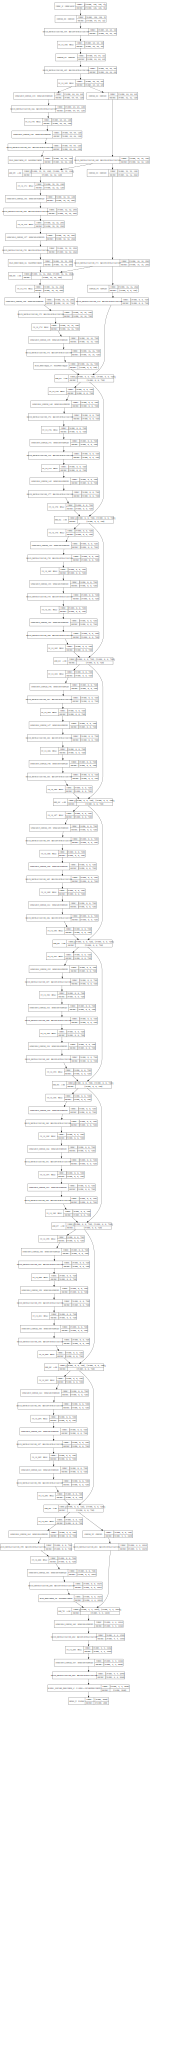

In [73]:
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import pydot
import graphviz

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True, rankdir='TB',expand_nested=False, dpi=60, subgraph=False).create(prog='dot',format='svg'))

In [47]:
import tensorflow.keras.backend as K 
np.sum([K.count_params(p) for p in model.trainable_weights])

21216752

In [48]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# trained = model.fit_generator(train_generator,
#                 validation_data=val_generator,
#                 epochs=25,
#                 validation_steps=len(val_generator))

Due to low configuration of pc, I reduced the epoch 25 to 1.


In [53]:


trained = model.fit_generator(train_generator,
                validation_data=val_generator,
                epochs=1,
                validation_steps=len(val_generator))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


782/782 [==============================] - 614s 785ms/step - loss: 1.3750 - accuracy: 0.6508 - val_loss: 4.4239 - val_accuracy: 0.2110


In [38]:
validation_steps=len(val_generator)  
print(validation_steps)

157


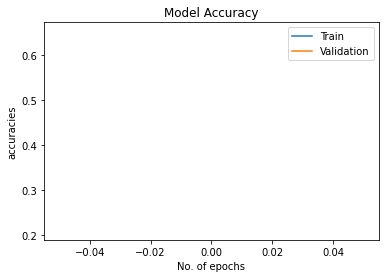

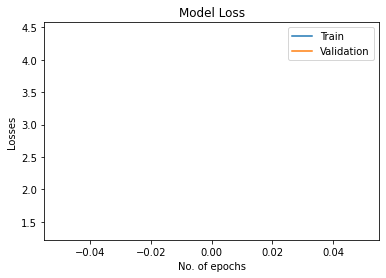

In [54]:
 # Ploting accuracies and losses with epochs

import matplotlib.pyplot as plt

plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('No. of epochs')
plt.ylabel('accuracies')
plt.legend(['Train','Validation'])
plt.show()

plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('No. of epochs')
plt.ylabel('Losses')
plt.legend(['Train','Validation'])
plt.show()

In [55]:
prediction=model.predict_generator(test_generator, steps=len(test_generator))
prediction.shape

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(10000, 200)

In [56]:
prediction_index= np.argmax(prediction, axis=1)
prediction_index.shape

(10000,)

In [58]:
labels=train_generator.class_indices
print(type(labels), len(labels))

<class 'dict'> 200


In [59]:
labels = dict((value,key) for key,value in labels.items())
# labels
predicted_class = [labels[k] for k in prediction_index]
len(predicted_class)
# predicted_class

10000

In [60]:
filenames_ = test_generator.filenames
filenames_

filenames=[]

for e in filenames_:
    e = e[7:]
    filenames.append(e)

In [61]:
results = pd.DataFrame({"file_name":filenames, "category":predicted_class})
results.head()

,file_name,category
0,test_0.JPEG,n02123394
1,test_1.JPEG,n07711569
2,test_10.JPEG,n07583066
3,test_100.JPEG,n04507155
4,test_1000.JPEG,n02132136


In [62]:
results.to_csv('results.csv', index=False)

In [63]:
from google.colab import files
files.download('results.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>